### first run docker from docker hub: amiklos/mriqc:1.1R
### open terminal and 
### 1. python -m pip install --upgrade pip
### 2. pip install pymc3
### 3. conda install -c conda-forge seaborn=0.12.2
### 4. python -m pip install -U matplotlib
### then:

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats
from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [3]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%qtconsole

In [4]:
clinuse = pd.read_csv('/src/notebooks/MADRS_hash.csv')
clinuse

,Unnamed: 0,madrs,time,event,id_hash
0,0,37.0,1,Baseline,94c668d3941a0597c05d4277597c2460c5235d8b
1,1,35.0,2,Week 1,94c668d3941a0597c05d4277597c2460c5235d8b
2,2,30.0,3,Week 2,94c668d3941a0597c05d4277597c2460c5235d8b
3,3,29.0,4,Week 3,94c668d3941a0597c05d4277597c2460c5235d8b
4,4,24.0,5,Week 4,94c668d3941a0597c05d4277597c2460c5235d8b
...,...,...,...,...,...
226,226,0.0,5,Week 4,a3d4f43f589460bac7918e1c91a76e318370d197
227,227,0.0,6,Week 5,a3d4f43f589460bac7918e1c91a76e318370d197
228,228,34.0,1,Baseline,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e
229,229,35.0,2,Week 1,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e


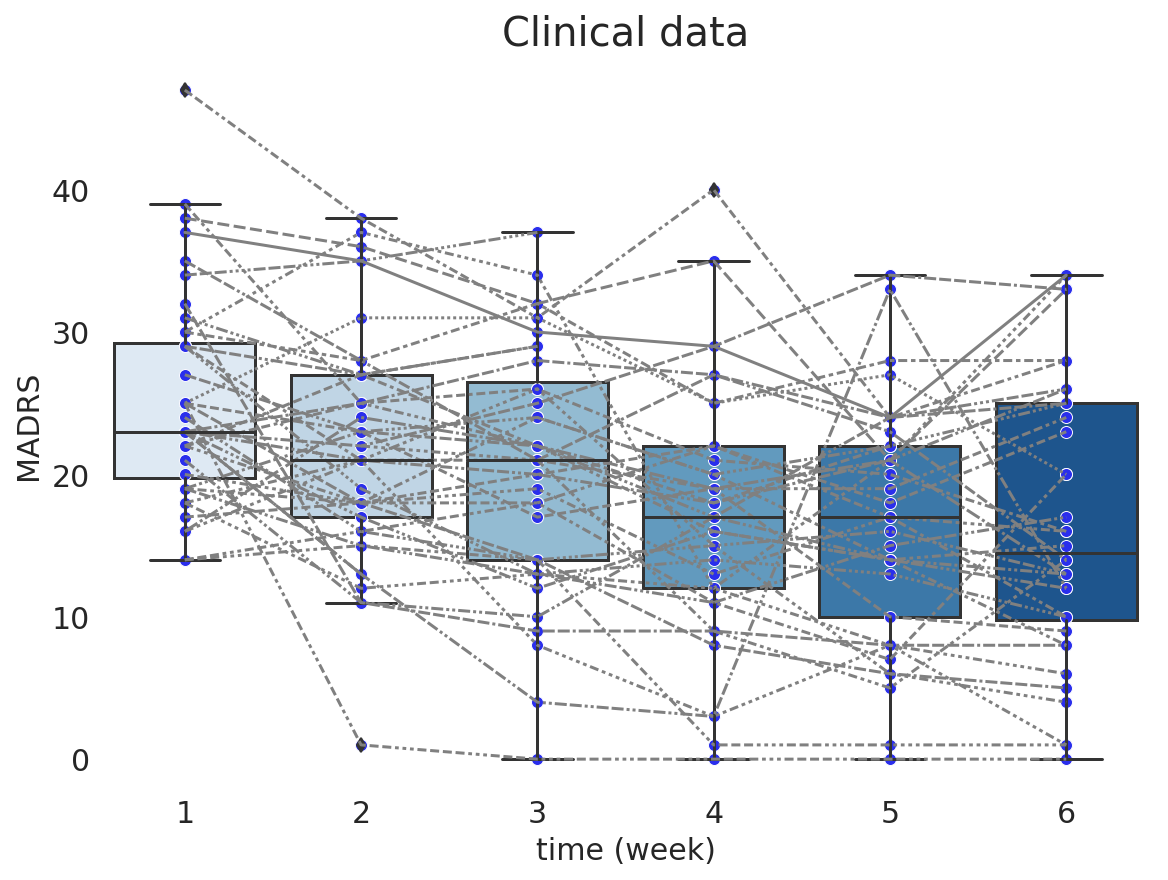

In [5]:

import seaborn as sns
clinuse['time0'] = clinuse['time']-1
sns.set_style("ticks", {"grid.color": "grey", "grid.linestyle": ":"})
bar,ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x="time", y="madrs", data=clinuse, palette='Blues')
_=sns.scatterplot(data=clinuse, y="madrs", x="time0")
_=sns.lineplot(data=clinuse, y="madrs", x="time0", style="id_hash", color='grey',legend=None)
#sns.lineplot(data=clinuse, y="madrs", x="time0")
_=ax.set_title("Clinical data", fontsize=20)
_=ax.set_xlabel ("time (week)", fontsize=15)
_=ax.set_ylabel ("MADRS", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.grid(False)

In [6]:
Nsubj = len(np.unique(clinuse.id_hash))
code = pd.DataFrame({'id_hash':list(np.unique(clinuse.id_hash)), 'sbj':list(range(Nsubj))})
clinuse['sbj'] = np.zeros(clinuse.shape[0]).astype(int)

for i in range(Nsubj):
    indx = np.where(clinuse.id_hash == code.id_hash[i])
    clinuse.loc[indx[0],'sbj'] = code.sbj[i]
clinuse


,Unnamed: 0,madrs,time,event,id_hash,time0,sbj
0,0,37.0,1,Baseline,94c668d3941a0597c05d4277597c2460c5235d8b,0,26
1,1,35.0,2,Week 1,94c668d3941a0597c05d4277597c2460c5235d8b,1,26
2,2,30.0,3,Week 2,94c668d3941a0597c05d4277597c2460c5235d8b,2,26
3,3,29.0,4,Week 3,94c668d3941a0597c05d4277597c2460c5235d8b,3,26
4,4,24.0,5,Week 4,94c668d3941a0597c05d4277597c2460c5235d8b,4,26
...,...,...,...,...,...,...,...
226,226,0.0,5,Week 4,a3d4f43f589460bac7918e1c91a76e318370d197,4,28
227,227,0.0,6,Week 5,a3d4f43f589460bac7918e1c91a76e318370d197,5,28
228,228,34.0,1,Baseline,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e,0,8
229,229,35.0,2,Week 1,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e,1,8


In [21]:
np.unique(clinuse.sbj)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])

In [23]:
sbj=clinuse.sbj.astype(int).values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#ef=ss.fit_transform(nmdata['Max_Intensity.1'].values.reshape(-1,1)).ravel()#remove extra bracket
#vol=ss.fit_transform(nmdata['dvol'].values.reshape(-1,1)).ravel() #remove extra bracket

with pm.Model() as c_1_1:
    # hyper-priors
    madrs=pm.Data('madrs', clinuse.madrs)
    time = pm.Data('time', clinuse.time)
    a_bar = pm.Normal("a_bar", 20.0, 15.0 )
    b_bar = pm.Normal("b_bar", 0.0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_b = pm.Exponential("sigma_b", 1.0)
    sigma = pm.Exponential("sigma", 1.0)
    # adaptive priors
    a = pm.Normal("a", a_bar, sigma_a, shape=Nsubj)
    b = pm.Normal("b", b_bar, sigma_b, shape=Nsubj)
    mu = pm.Deterministic("mu", a[sbj] + b[sbj] * time)
    #mu = a[sbj] + b[sbj]*nmdata['Max_Intensity.1']
    M = pm.Normal("M", mu, sigma, observed=madrs)
    
    #trace_1_2 = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)
    #trace_clin_1_1 = pm.sample(random_seed=RANDOM_SEED)
    #idata_clin_1_1 = az.from_pymc3(trace_clin_1_1)

In [24]:
with c_1_1:
    prior =  pm.sample_prior_predictive()
    trace = pm.sample(tune=3000, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(trace)
    c_1_1_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

/opt/conda/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma, sigma_b, sigma_a, b_bar, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 20 seconds.


In [30]:
code

,id_hash,sbj
0,001bda980325893f81559bd2805fd2ecee67abcd,0
1,0b040b3e4be11aa8c02c1fb5bdd35c5d88ecd018,1
2,0dd15be62d0a5893aee45eb0c8e4a2f10bc9284e,2
3,0eeb8b7678ab70efca95da9606b8b2a7a3b61909,3
4,161435de205e989ffa970d599060db2d30dbb1ae,4
5,189fb2cc5d71fbca119f005e2cc89b40ec0bbd49,5
6,1a9548a0c50881d1e25c7ee2f9191f160fad4554,6
7,1c8838b784ebd917dc8b7a84fa45e22d40f411f5,7
8,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e,8
9,28bae20aae2defa504da15f7f201ede335102a72,9


In [31]:
#cd = np.unique(clinuse[['sbj','id_hash']], axis=0)
#cd = clinuse[['sbj','id_hash']].drop_duplicates().reset_index()

#if sbj is not in order make sure that the c_1_1 and your reading is in the same order!!

res = pd.DataFrame(columns=['sbj','id_hash','slope','intercept'])

for i in range(code.shape[0]):
    #print(i)
    j=code.sbj[i]
    ideg = pd.DataFrame([code['sbj'].iloc[i], code['id_hash'].iloc[i], c_1_1_idata['posterior']['b'].mean(dim=['chain','draw']).values[i],  c_1_1_idata['posterior']['a'].mean(dim=['chain','draw']).values[i]]).T
    ideg.columns=['sbj','id_hash','slope','intercept']
    res = pd.concat([res, ideg], ignore_index=True)
res    


,sbj,id_hash,slope,intercept
0,0,001bda980325893f81559bd2805fd2ecee67abcd,-0.966511,34.557744
1,1,0b040b3e4be11aa8c02c1fb5bdd35c5d88ecd018,-1.50067,38.050717
2,2,0dd15be62d0a5893aee45eb0c8e4a2f10bc9284e,-2.781211,22.914993
3,3,0eeb8b7678ab70efca95da9606b8b2a7a3b61909,-0.632787,22.304584
4,4,161435de205e989ffa970d599060db2d30dbb1ae,-2.399346,24.815321
5,5,189fb2cc5d71fbca119f005e2cc89b40ec0bbd49,-1.441507,22.631497
6,6,1a9548a0c50881d1e25c7ee2f9191f160fad4554,-1.04649,30.788847
7,7,1c8838b784ebd917dc8b7a84fa45e22d40f411f5,-1.050411,29.553874
8,8,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e,-0.491104,33.855865
9,9,28bae20aae2defa504da15f7f201ede335102a72,-1.323738,21.397934


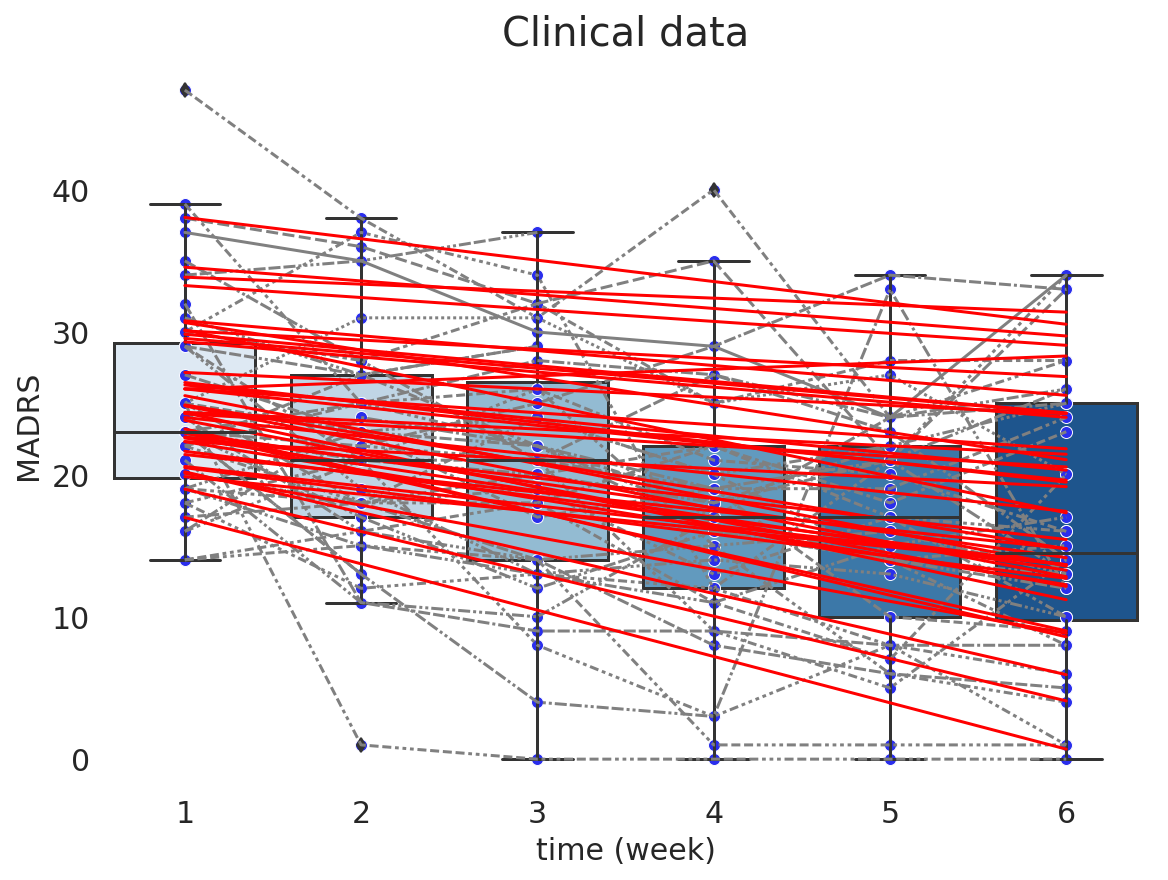

In [32]:
import seaborn as sns
x = np.array([0, 1, 2, 3, 4, 5])
clinuse['time0'] = clinuse['time']-1
sns.set_style("ticks", {"grid.color": "grey", "grid.linestyle": ":"})
bar,ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x="time", y="madrs", data=clinuse, palette='Blues')
_=sns.scatterplot(data=clinuse, y="madrs", x="time0")
_=sns.lineplot(data=clinuse, y="madrs", x="time0", style="id_hash", color='grey',legend=None)
for i in range(res.shape[0]):
    # Create the line equation
    line = res['slope'].iloc[i] * x + res['intercept'].iloc[i]

    # Plot the line
    _ = plt.plot(x, line, color='red')

_=ax.set_title("Clinical data", fontsize=20)
_=ax.set_xlabel ("time (week)", fontsize=15)
_=ax.set_ylabel ("MADRS", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.grid(False)

In [33]:
resid = clinuse[['id_hash']].drop_duplicates().merge(res,on='id_hash')

#resid.to_csv('/src/notebooks/TMS/clin-slope-rTMS10Hz-hash.csv')

In [16]:
dist=pd.read_csv('/src/notebooks/TMS/Distance-rTMS10Hz-hash.csv')
dist

,Unnamed: 0,dist,id_hash
0,0,6.850366,189fb2cc5d71fbca119f005e2cc89b40ec0bbd49
1,1,15.772930,0eeb8b7678ab70efca95da9606b8b2a7a3b61909
2,2,26.519243,28bae20aae2defa504da15f7f201ede335102a72
3,3,30.591605,161435de205e989ffa970d599060db2d30dbb1ae
4,4,21.449725,8874006084fe8e32904e6e83a54e098c965302a8
5,5,8.084501,94c668d3941a0597c05d4277597c2460c5235d8b
6,6,18.061072,f6463c25418b6773c9358c41d759cd3207f66bd7
7,7,4.211994,51e5a2e2481e577ff5a491fa1e628adc8eb57c04
8,8,7.252783,0b040b3e4be11aa8c02c1fb5bdd35c5d88ecd018
9,9,22.023257,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e


In [34]:
clinslope = pd.read_csv('/src/notebooks/TMS/clin-slope-rTMS10Hz-hash.csv')
clinall = clinuse.merge(clinslope, on = 'id_hash')

medresp = np.median(clinall['slope'])
clinall['resp'] = 1
clinall['resp'].iloc[np.where(clinall['slope']>medresp)] = 0
clinall

/tmp/ipykernel_12832/3370072920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinall['resp'].iloc[np.where(clinall['slope']>medresp)] = 0


,Unnamed: 0_x,madrs,time,event,id_hash,time0,sbj_x,Unnamed: 0_y,sbj_y,slope,intercept,resp
0,0,37.0,1,Baseline,94c668d3941a0597c05d4277597c2460c5235d8b,0,26,0,26,-0.839283,33.266023,0
1,1,35.0,2,Week 1,94c668d3941a0597c05d4277597c2460c5235d8b,1,26,0,26,-0.839283,33.266023,0
2,2,30.0,3,Week 2,94c668d3941a0597c05d4277597c2460c5235d8b,2,26,0,26,-0.839283,33.266023,0
3,3,29.0,4,Week 3,94c668d3941a0597c05d4277597c2460c5235d8b,3,26,0,26,-0.839283,33.266023,0
4,4,24.0,5,Week 4,94c668d3941a0597c05d4277597c2460c5235d8b,4,26,0,26,-0.839283,33.266023,0
...,...,...,...,...,...,...,...,...,...,...,...,...
226,226,0.0,5,Week 4,a3d4f43f589460bac7918e1c91a76e318370d197,4,28,39,28,-3.254242,16.975177,1
227,227,0.0,6,Week 5,a3d4f43f589460bac7918e1c91a76e318370d197,5,28,39,28,-3.254242,16.975177,1
228,228,34.0,1,Baseline,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e,0,8,40,8,-0.491104,33.855865,0
229,229,35.0,2,Week 1,20bb5d03c52aa3d1a2d0f4ab1c0e8c58082ef35e,1,8,40,8,-0.491104,33.855865,0


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


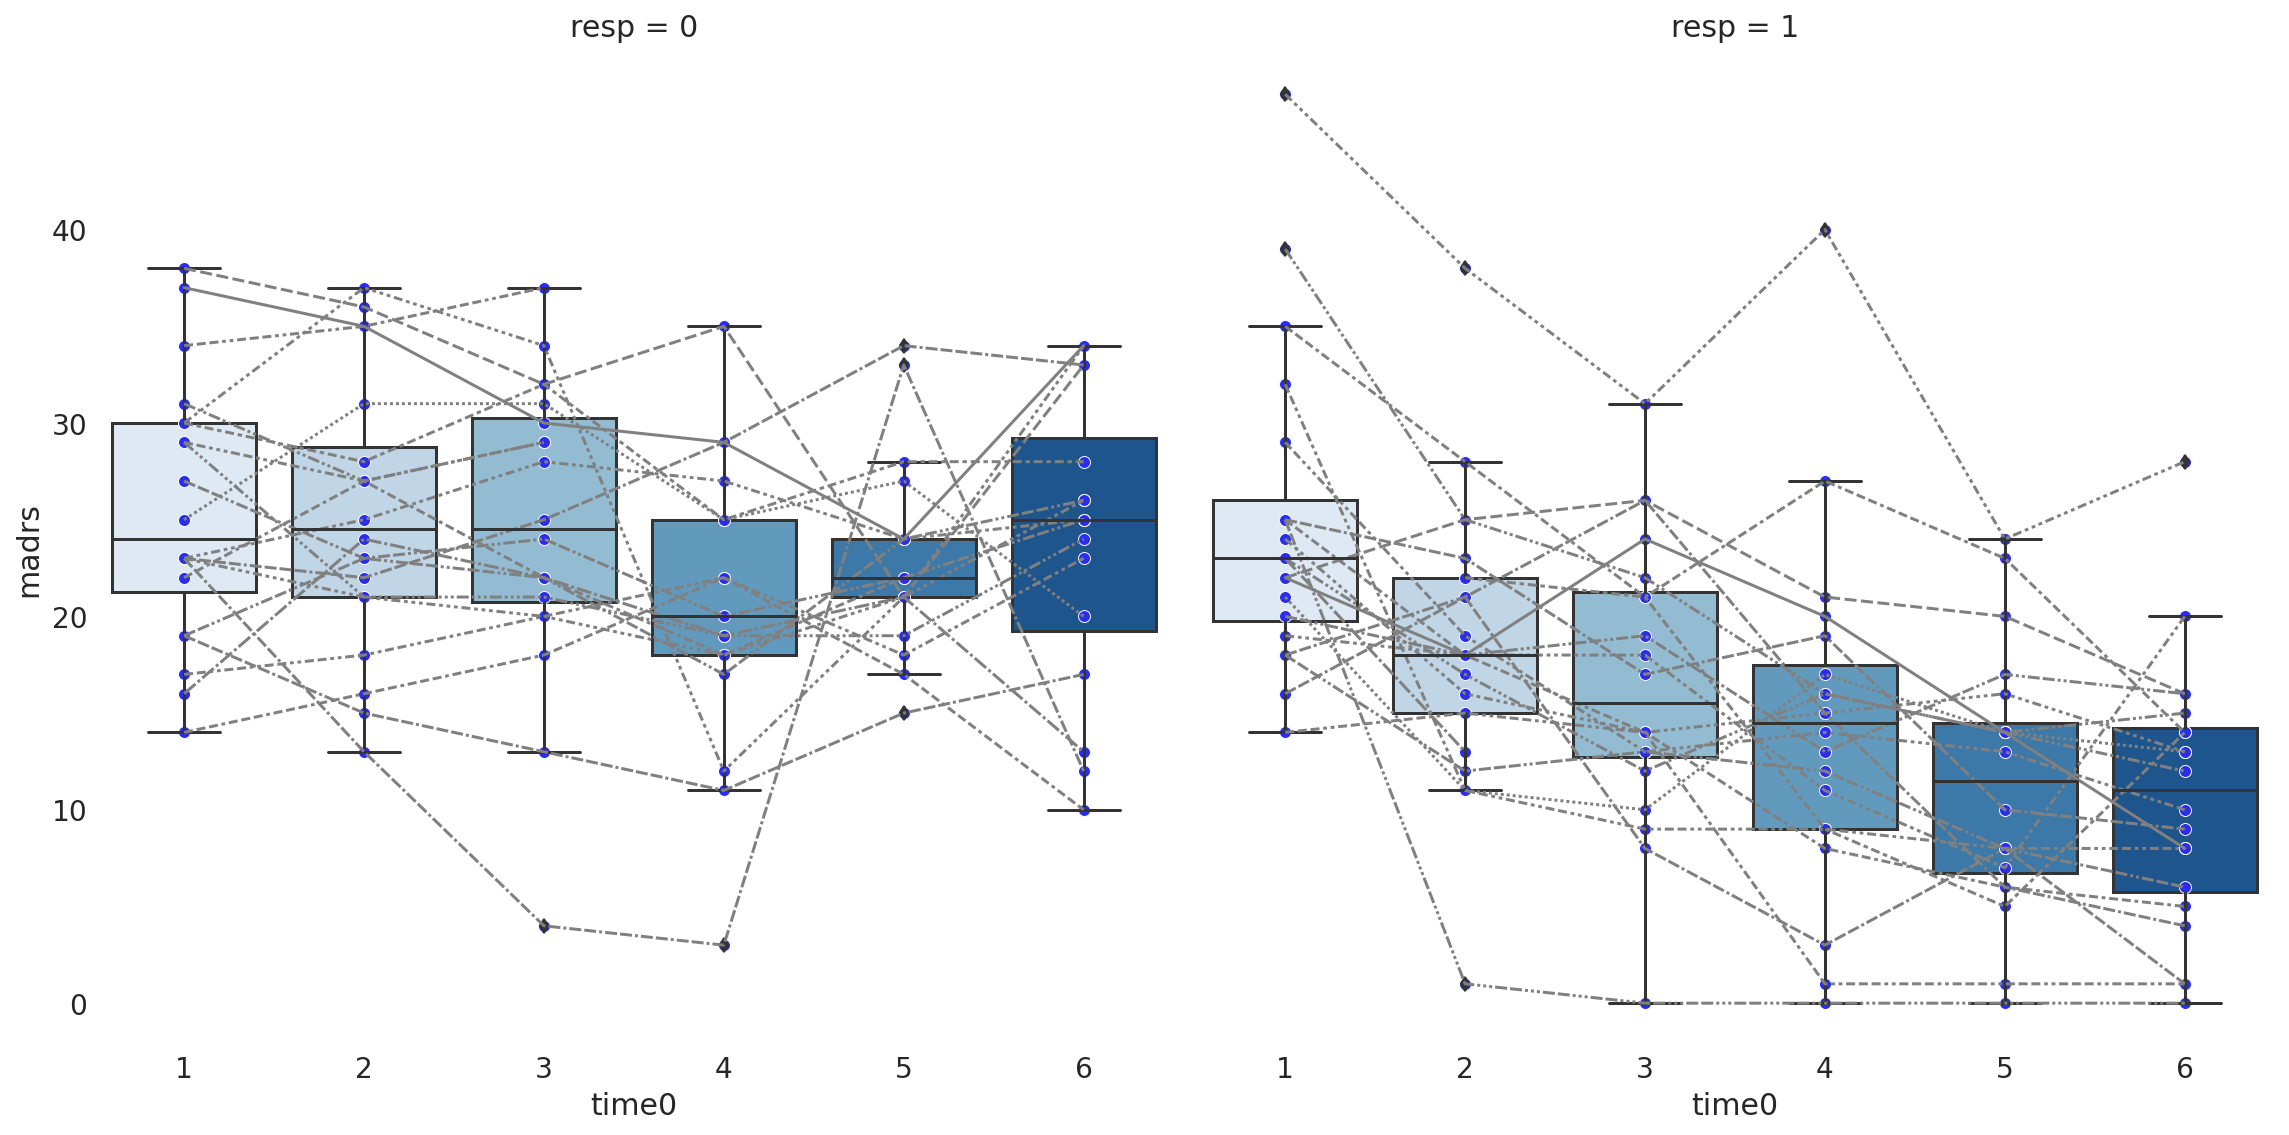

In [35]:
g = sns.FacetGrid(clinall, col='resp', col_wrap=2, height=8)

# Map a scatter plot to the grid
_=g.map_dataframe(sns.boxplot, x='time', y='madrs', palette='Blues')
_=g.map_dataframe(sns.scatterplot, x='time0', y='madrs')
_=g.map_dataframe(sns.lineplot, x='time0', y='madrs', style='id_hash', color='grey', legend=None)

In [36]:
clinslope.merge(dist, left_on = 'id_hash', right_on='id_hash').to_csv('/src/notebooks/TMS/rTMS10-clin-dis-hash.csv')

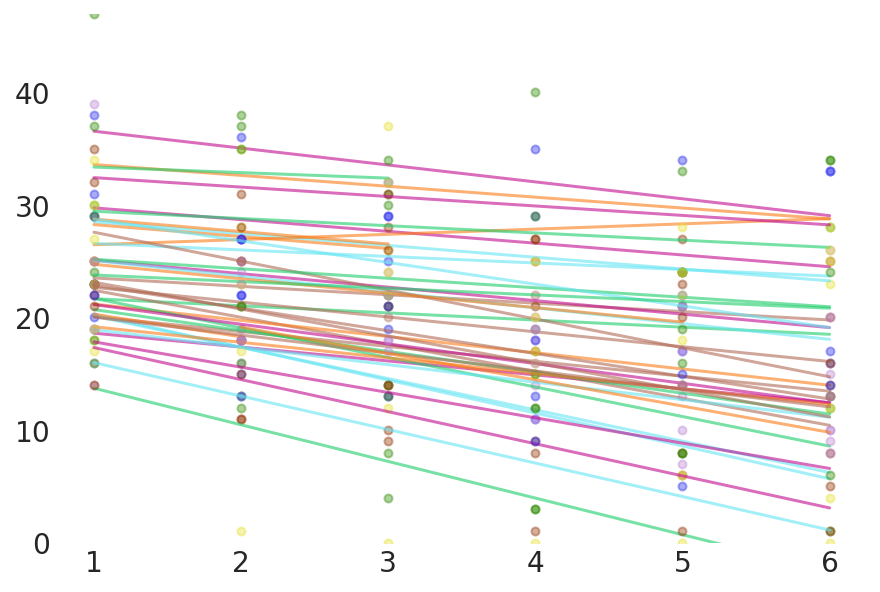

In [37]:
_, ax = plt.subplots()

for i in range(41):
  
  mreg=i
  ix = np.where(clinuse.sbj==mreg)[0]
  if (ix.size!=0):
    ax.plot(clinuse.time.iloc[ix], clinuse.madrs.iloc[ix], "o", ms=4, alpha=0.4, label="Data") 
    #m, b = np.polyfit(clinuse.madrs.iloc[ix], ppc["M"].mean(0)[ix],1)
    ax.plot(clinuse.time.iloc[ix], c_1_1_idata['posterior']['b'][:,:,mreg].mean().values*clinuse.time.iloc[ix]+c_1_1_idata['posterior']['a'][:,:,mreg].mean().values, label="Mean outcome", alpha=0.6)
    #ax.set_title('Subject: ' + str(i))

    #plt.savefig('./Abbott/testfig_'+str(i)+'.pdf')
    #plt.show()
  #print(i)
plt.ylim([0,clinuse.madrs.values.max()])
plt.show();